In [1]:
import exportnb
exportnb.export_notebooks(['./210618 - Functions_for_import.ipynb'])
import setup

In [2]:
import importlib
importlib.reload(setup)

<module 'setup' from '/home/guillermo/Nextcloud/superqulan/Programs/Programs Disrtributed Q Gates/210802 - Guillermo_Programs_Purcell/setup.py'>

In [3]:
import numpy as np
import os.path
from numpy import pi, floor, sqrt
from math import pi as π
import scipy.sparse as sp
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import setup

In [4]:
styles = ['science']
prefix = '../stylelib/'
sufix = '.mplstyle'
for i in range(len(styles)):
    styles[i] = prefix + styles[i] + sufix
plt.style.use(styles)
plt.rcParams.update({'font.size': 20, 'text.usetex': False})

We create the following function to map a job over multiple cores. We can do this for this notebook because the simulations only use one processor, because of the sparse matrices.

In [13]:
import multiprocessing as mp

_func = None

def worker_init(func):
    global _func
    _func = func

def worker(x):
    try:
        return _func(x)
    except Exception as e:
        print(e)
        raise e

def job(f, data, ncores=None, single=False):
    if mp.get_start_method() == 'fork' and not single:
        if ncores is None:
            ncores = mp.cpu_count()//2
        with mp.Pool(ncores, initializer=worker_init, initargs=(f,)) as p:
            output = p.map(worker, data)
    else:
        output = [f(d) for d in data]
    return output

# Purcell filters

The analysis of the Purcell effect leaves us with two bosonic modes which interact via displaced frequencies and couplings. If $x=\pm 1$ is the state of the dispersively coupled qubit,
$$ \bar{H}_c = \begin{pmatrix} a^\dagger & b^\dagger \end{pmatrix}
    \begin{pmatrix}
    \Omega + \chi q_a x & g_p + \frac{1}{2}\chi q_b x \\
    g_p + \frac{1}{2}q_b x & \Omega
    \end{pmatrix}
    \begin{pmatrix} a \\ b \end{pmatrix} =
    \vec{A}^\dagger \left[\left(\Omega+\frac{1}{2}\chi q_a x\right)\mathbb{I}
    + \frac{1}{2}\chi q_a x \sigma^z + \left(g_p + \frac{1}{2}\chi q_b x\right)\sigma^x
    \right]
    \vec{A}.
    $$

The shifts $\chi$ are given by the qubit-cavity coupling and the qubit-resonator detuning
$$\chi = \frac{g^2}{\Delta},\quad \text{with} \quad \Delta = \delta-\Omega. $$
The weights of the displacements depend on the coupling between cavities and their detunings
$$
   q_a=\frac{1}{1-(g_p/\Delta)^2}, \label{qa}\\
   q_b =\frac{(g_p/\Delta)}{1-(g_p/\Delta)^2}.
$$

The qubit's decay is reduced from the original cavity decay by two factors
$$\gamma = \kappa \times q_a^2 \times \left( \frac{g}{\Delta} \right)^2.$$

The photon faces this collection of modes and sees two resonances for each value of $s$
$$\omega_\pm(s) = \Omega + \frac{1}{2}\chi q_a \pm \sqrt{\left(\frac{\chi q_a}{2}\right)^2 + \left(G + \frac{\chi q_b}{2}s\right)^2}.$$
Each of these modes has its own $\kappa_\pm(s)$ that results from reducing $\kappa$ by the probability that the mode $b$ is occupied.

When an incoming photon with frequency $\omega$ collides against these modes, it experiences a phase shift
$$f(\omega) \to f(\omega) \frac{i(\omega - \omega_+(s)) + \kappa_+(s)}{i(\omega - \omega_+(s)) - \kappa_+(s)} \frac{i(\omega - \omega_-(s)) + \kappa_-(s)}{i(\omega - \omega_-(s)) - \kappa_-(s)}.$$

Each of these modes has its own $\kappa$ which results from reducing $\kappa$ by the amplitude of the mode $b$ in the diagonalization. From the previous diagonalization, the quadratic form is
\begin{align}
C & = \left(\Omega+\frac{1}{2}\chi q_a s\right)\mathbb{I}
    + \frac{1}{2}\chi q_a s \sigma^z + \left(G + \frac{1}{2}\chi q_b s\right)\sigma^x \\
  & = \left(\Omega+\frac{1}{2}\chi q_a s\right)\mathbb{I} + \sqrt{\left(\frac{\chi q_a}{2}\right)^2 + \left(G + \frac{\chi q_b}{2}s\right)^2} \times \sigma.
\end{align}
with
$$\sigma = \left[\left(\frac{\chi q_a}{2}\right)^2 + \left(G + \frac{\chi q_b}{2}s\right)^2\right]^{-1/2}
\times \left[\frac{1}{2}\chi q_a s \sigma^z + \left(G + \frac{1}{2}\chi q_b s\right)\sigma^x\right].$$

In [26]:
def plot_phases(κ = 2*π*100e-3, rg=0.2, rG=0.05, rδ=.0, l=30, quiet=False):
    
    # rg, rG, rδ are some convenient parameters to define the relevant ones of the problem
    
    χ = κ / 2
    g = χ / rg  # 100 MHz
    δ = g**2/χ * (1+ rδ)
    χ = g**2/δ
    G = rG*δ
    
    qa = 1/(1 - (G/δ)**2)
    qb = (G/δ)*qa
    
    γ = κ * (qb*g/δ)**2  # Decay of the qubit, appropriately supressed by the Purcell filter.

    if not quiet:
        print(f'χ = 2π x {g**2/δ/(2*π):.3f} GHz')
        print(f'κ = 2π x {κ/(2*π):.3f} GHz')
        print(f'g = 2π x {g/(2*π):.3f} GHz')
        print(f'δ = 2π x {δ/(2*π):.3f} GHz')
        print(f'G = 2π x {G/(2*π):.3f} GHz')
        print(f'qb = {qb:.3f}')
        print(f'γ = 2π x {γ/(2*π)*1000:.3f} MHz')
        print(f'T1 = 1/γ = {1/γ/1000:.0f} μs')
    
    ω1 = 2*π*8.40701933547913  # central frequency of the incoming photon (in GHz)
    Ω = ω1 + G  # we choose to work in the plus resonance. This plus refers to the resonators, we still can have Q2 in p or m.
    
    '''We now define the quadratic forms for both possible states of Q2. We diagonalize to obtain the state dependent frequency,
    and the state dependent decay rate (the latter based on the population of the mode).'''
    Cp = np.array([[Ω + χ*qa*(+1), G + 0.5*χ*qb*(+1)],
                   [G + 0.5*χ*qb*(+1), Ω]])  # Quadratic form for the case Q2 is in plus
    Ωp, Up = np.linalg.eigh(Cp)
    κp = np.abs(Up[1,:])**2 * κ
    
    Cm = np.array([[Ω + χ*qa*(-1), G + 0.5*χ*qb*(-1)],
                   [G + 0.5*χ*qb*(-1), Ω]])  # Quadratic form for the case Q2 is in minus
    Ωm, Um = np.linalg.eigh(Cm)
    κm = np.abs(Um[1,:])**2 * κ
    if not quiet:
        print(f'Ωp = 2π x {Ωp/(2*π)} GHz')
        print(f'κp = 2π x {κp/(2*π)} GHz')
        print(f'Ωm = 2π x {Ωm/(2*π)} GHz')
        print(f'κm = 2π x {κm/(2*π)} GHz')
    
    '''Once all of the state dependent frequencies and decays have been constructed, we go ahead and calculate
    the phase change of an incoming photon based on the input output formula'''
    control = setup.Exp2QB2Cavities(ω1=ω1, ω2=Ω, δ2=0, g2=0, κ1=0, κ2 = 2*π*1e-3*100, l=l, mmax=2101) 
    if True:
        ω = np.linspace(Ω-2*max(G, χ), Ω + 2*max(G, χ), 201)
        ω = ω.reshape(ω.size, -1)
        eiphp = np.prod((1j*(ω - Ωp) + κp/2)/(1j*(ω - Ωp) - κp/2), axis=-1)
        eiphm = np.prod((1j*(ω - Ωm) + κm/2)/(1j*(ω - Ωm) - κm/2), axis=-1)
    else:
        χ = 0.5 * κ
        ω = np.linspace(Ω - 3*κ, Ω + 3*κ, 101)
        eiphp = (1j*(ω - (Ω+χ)) + κ/2)/(1j*(ω - (Ω+χ)) - κ/2)
        eiphm = (1j*(ω - (Ω-χ)) + κ/2)/(1j*(ω - (Ω-χ)) - κ/2)
    
    fig, ax1 = plt.subplots(ncols=1, figsize=(6,5))
    ax1.plot(ω.flatten()/(2*π), np.angle(eiphp)/π, label = 'Q2 plus')
    ax1.plot(ω.flatten()/(2*π), np.angle(eiphm)/π, '--', label = 'Q2 minus')
    ax1.plot(ω.flatten()/(2*π), np.angle(eiphp * eiphm.conj())/π,  label = 'total phase')
    ax1.plot([ω1/(2*π)]*2, [-1,1], 'k-.')
    ax1.legend()

In [ ]:
plot_phases(rG=0.015, rg=0.2)

In [ ]:
plot_phases(rG=0.025, rg=0.1, rδ=0.05)

We try to avoid overflows in the definition of the wavefunction. Essentially
$$\Psi(\omega) \propto \mathrm{sech}(\omega \pi/\kappa) \propto \frac{1}{e^{x}+e^{-x}} = \frac{e^{-x}}{1 + e^{-2x}},$$
with $x=|\omega\pi/\kappa|.$

In [24]:
def sech_photon2(ω, κ):
    if False:
        γ4 = 1/np.cosh(π*ω/κ)*1/κ**0.5
    else:
        f = np.exp(-np.abs(π*ω/κ))
        γ4 = f/(1 + f*f)
    return γ4/np.linalg.norm(γ4)

We have a transformation $U$ that we compare with the ideal one $U_{id}$. The fidelity for a given input state is
$$F[\psi] = \frac{\left|\langle{\psi|U_{id}^\dagger U|\psi}\rangle\right|^2}{\left|\langle{\psi|\psi}\rangle\right|^2}.$$

In [25]:
def min_fidelity(U):
    def cost(x):
        ψ = [x[0]+1j*x[1], x[2]+1j*x[3]]
        return np.abs(np.vdot(ψ, U@ψ)/np.vdot(ψ, ψ))**2
    
    res = scipy.optimize.minimize(cost, [1, 0, 1, 0])
    return res.fun

In [28]:
import scipy.optimize

def input_output_estimation(η=1.0, κ=2*π*1e-3*100, l=30, ηmax=10, npoints=42, ω1=None,
                            mmax=2101, rg=0.2, rG=0.05, T1=100e-6, quiet=False, plot=False):
    χ = κ / 2
    g = χ / rg # 100 MHz
    δ = g**2/χ
    G = rG*δ
    
    mmax = min(mmax, int(2101/30*l))
    if ω1 is None:
        if l == 5:
            ω1 = 2*π*8.416408398466828
        else:
            ω1 = 2*π*8.40701933547913

    def parameters(δ):
        
        '''Returns the relevant parameters for considering a Purcell filter.'''

        χ = g**2/δ
        qa = 1/(1 - (G/δ)**2)
        qb = (G/δ)*qa
        γ = κ * (qb*g/δ)**2
        return γ, χ, qa, qb
    
    Ω = ω1 + G
    control = setup.Exp2QB2Cavities(ω1=ω1, ω2=Ω, l=l, δ2=0, g2=0, κ1=0, κ2=2*π*1e-3*100, mmax=mmax)

    def phases(δ):
        
        '''Function that calculates the phases after scattering.'''
        
        γ, χ, qa, qb = parameters(δ)
        Cp = np.array([[Ω + χ*qa*(+1), G + 0.5*χ*qb*(+1)],
                       [G + 0.5*χ*qb*(+1), Ω]])
        Ωp, Up = np.linalg.eigh(Cp)
        κp = np.abs(Up[1,:])**2 * κ
        
        Cm = np.array([[Ω + χ*qa*(-1), G + 0.5*χ*qb*(-1)],
                       [G + 0.5*χ*qb*(-1), Ω]])
        Ωm, Um = np.linalg.eigh(Cm)
        κm = np.abs(Um[1,:])**2 * κ
        
        ωr = ω.reshape(ω.size, -1)  # I do not see where this ω has been defined.
        eiphp = np.prod((1j*(ωr - Ωp) + κp/2)/(1j*(ωr - Ωp) - κp/2), axis=-1)
        eiphm = np.prod((1j*(ωr - Ωm) + κm/2)/(1j*(ωr - Ωm) - κm/2), axis=-1)
        return eiphp, eiphm

    Ψ = sech_photon2(control.ωrelevant - control.ω1, κ/η)  # We construct the photonic wave function
    ω = control.ωrelevant.copy()
    tprop = control.tprop
    ω_linear = control.ω1-(control.mcentral*π/l - control.mrelevant*π/l)*l/control.tprop  # linear dispersion relation, necessary to compare with undistorted cases.

    def pulses(δ):
        
        '''Calculates the photon after scattering and realistic propagation and returns the e ang g cases, 
        there is already an asymmetry here, since the e cases compensates while the g adds up.'''
        
        eiphp, eiphm = phases(δ)
        e_real = Ψ*eiphp*np.exp(-1j*2*control.tprop*(ω))
        g_real = Ψ*eiphm*np.exp(-1j*2*control.tprop*(ω))
        return e_real, g_real
    
    
    def overlaps(δ):
        zeg = np.vdot(*(pulses(δ)))  # New use uf vdot for me.
        if False:
            print(f'angle/π = {np.angle(zeg)/π}, z = {zeg}, χ=2π x {g**2/δ/(2*π):.3f} GHz')
        return zeg

    
    def cost(δ):
        return np.abs(1 + overlaps(δ))
    
    
    
    δopt, fval, _, _ = scipy.optimize.fminbound(cost, δ*1.0, δ*1.2, full_output=True)
    
    def min_fidelity2(z_e, z_g):
        
        '''Calculates the fidelity of the complete gate according to (S22)'''
        
        r = np.abs(z_g/z_e) 
        if r > 1:  # fixes if there is a missmatch somewhere between who is e and who is g. If all consistent, r<1 always.
            z_g, z_e = z_e, z_g
            r = 1/r
        φ = π - np.angle(z_e.conj() * z_g)
        if (1+r*np.cos(φ))/(1+r*r+2*r*np.cos(φ)) <= 1:
            f = np.sin(φ)**2/(1+r*r+2*r*np.cos(φ))
        else:
            f = 1
        return f * np.abs(z_g)**2
 


    def fidelity(δ):
        
        def ref_overlap(tdelay):
            '''Calculates the overlap between the refference photon and the real one.'''
            e_real, g_real = pulses(δ)
            e_ref = Ψ * np.exp(-1j*(π/2 + tdelay * ω) -1j*2*control.tprop*(ω_linear))
            g_ref = Ψ * np.exp(-1j*(-π/2 + tdelay * ω) -1j*2*control.tprop*(ω_linear))
            return np.vdot(e_ref, e_real),  np.vdot(g_ref, g_real)

        def avg_overlap(tdelay):
            A = ref_overlap(tdelay)
            overlap = np.sum(np.abs(np.diag(A))**2)
            return -overlap

        res = scipy.optimize.minimize(avg_overlap, 0, tol=1e-8)
        topt = res.x[0]
        z_e, z_g = ref_overlap(topt)
        F1 = min_fidelity2(z_e, z_g)
        if False:
            # Consistency check
            F2 = min_fidelity(np.diag([z_e, z_g]))
            if abs(F1 - F2) > 1e-5:
                raise Exception('Difference in the fidelities')
        return F1
    
    Fmin = fidelity(δopt)
    if plot:
        eiphp, eiphm = phases(δopt)
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(ω/(2*π), np.angle(eiphp)/(π))
        ax.plot(ω/(2*π), np.angle(eiphm)/(π))
        ax.plot(ω/(2*π), np.angle(eiphp*eiphm.conj())/(π))
        ax.plot(ω/(2*π), np.abs(Ψ))
        ax.set_xlim((Ω-2*G)/(2*π), (Ω+2*G)/(2*π))

    # tpulse is the duration of the control to emit / absorb a photon
    tpulse = 2*(10/(κ*0.5/η))
    # control.tprop is the time for the photon to travel along the guide once
    # the protocol takes twice that time, plus the time to reabsorb the photon
    tprotocol = tpulse + control.tprop*2
    # the pulse must be shorter than control.tprop*2, which sets a maximum
    # width
    κmin = 2*10/(2*control.tprop * 0.5)
    γ, χ, *_ = parameters(δopt)
    Fγ = np.exp(-γ*tprotocol)
    Fqb = Fγ * np.exp(-2*tprotocol/(T1/1e-9))
    print(parameters(δopt), δopt)
    if not quiet:
        print(f'χ  = 2π x {g**2/δ/(2*π):.3f} GHz\n'
              f'κ  = 2π x {κ/(2*π):.3f} GHz,  κmin = 2π x {κmin/(2*π):.3f} GHz\n'
              f'η  = {η}, ηmax = {κ/κmin:.1f}\n'
              f'g  = 2π x {g/(2*π):.3f} GHz\n'
              f'δ  = 2π x {δopt/(2*π):.3f} GHz\n'
              f'G  = 2π x {G/(2*π):.3f} GHz\n'
              f'Ω  = ω1 + {(Ω-ω1)/G:.3f}xG \n'
              f'γ  = 2π x {γ/(2*π)*1000:.3f} MHz\n'
              f'Tγ = {1/γ/1000:.0f} μs\n'
              f'T1 = {T1/1e-6:.0f} μs\n'
              f'tpulse = {tpulse/1000:.3f} μs = {tpulse/(2*control.tprop):.1f} * tprop\n'
              f'tproto = {tprotocol/1000:3f} μs\n'
              f'1-Fsc  = {1-Fmin:g} scattering fidelity\n'
              f'1-Fγ   = {1-Fγ:g} Purcell decay\n'
              f'1-Fqb  = {1-Fqb:g} qubit decay\n')

    return Fmin, Fγ, Fqb, γ, tprotocol

(2.8325270579089445e-06, 0.15707959681346378, 1.0009008103179216, 0.030027017453460814) 15.707966854552371
χ  = 2π x 0.025 GHz
κ  = 2π x 0.050 GHz,  κmin = 2π x 0.020 GHz
η  = 4, ηmax = 2.5
g  = 2π x 0.250 GHz
δ  = 2π x 2.500 GHz
G  = 2π x 0.075 GHz
Ω  = ω1 + 1.000xG 
γ  = 2π x 0.000 MHz
Tγ = 353 μs
T1 = 50 μs
tpulse = 0.509 μs = 1.6 * tprop
tproto = 0.829093 μs
1-Fsc  = 0.00750808 scattering fidelity
1-Fγ   = 0.00234567 Purcell decay
1-Fqb  = 0.034889 qubit decay



(0.9924919183033394,
 0.997654326758671,
 0.9651110054658083,
 2.8325270579089445e-06,
 829.0931011373029)

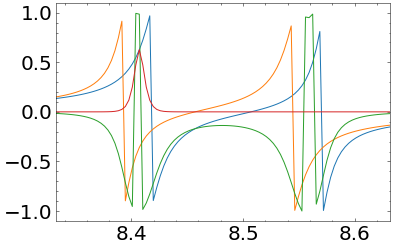

In [29]:
input_output_estimation(l=30, κ=2*π*50e-3, η=4, rG=0.03, rg=0.1, T1=50e-6, quiet=False, plot=True)

(5.665055654296614e-06, 0.314159214937059, 1.0009008104402397, 0.03002701949393113) 31.41593157809077
χ  = 2π x 0.050 GHz
κ  = 2π x 0.100 GHz,  κmin = 2π x 0.120 GHz
η  = 3, ηmax = 0.8
g  = 2π x 0.500 GHz
δ  = 2π x 5.000 GHz
G  = 2π x 0.150 GHz
Ω  = ω1 + 1.000xG 
γ  = 2π x 0.001 MHz
Tγ = 177 μs
T1 = 50 μs
tpulse = 0.191 μs = 3.6 * tprop
tproto = 0.244193 μs
1-Fsc  = 0.0210459 scattering fidelity
1-Fγ   = 0.00138241 Purcell decay
1-Fqb  = 0.0110892 qubit decay



(0.9789541368252513,
 0.9986175871208423,
 0.9889108371805221,
 5.665055654296614e-06,
 244.1934162348441)

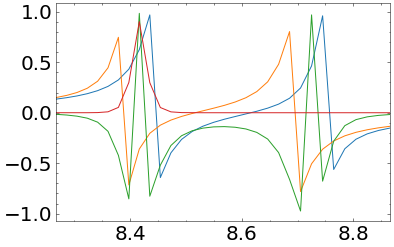

In [30]:
input_output_estimation(l=5, κ=2*π*100e-3, η=3, rG=0.03, rg=0.1, T1=50e-6, quiet=False, plot=True)

(2.8325270579089445e-06, 0.15707959681346378, 1.0009008103179216, 0.030027017453460814) 15.707966854552371
χ  = 2π x 0.025 GHz
κ  = 2π x 0.050 GHz,  κmin = 2π x 0.020 GHz
η  = 4, ηmax = 2.5
g  = 2π x 0.250 GHz
δ  = 2π x 2.500 GHz
G  = 2π x 0.075 GHz
Ω  = ω1 + 1.000xG 
γ  = 2π x 0.000 MHz
Tγ = 353 μs
T1 = 100 μs
tpulse = 0.509 μs = 1.6 * tprop
tproto = 0.829093 μs
1-Fsc  = 0.00750806 scattering fidelity
1-Fγ   = 0.00234567 Purcell decay
1-Fqb  = 0.0187522 qubit decay



(0.9924919376559233,
 0.997654326758671,
 0.9812477619874478,
 2.8325270579089445e-06,
 829.0931011373029)

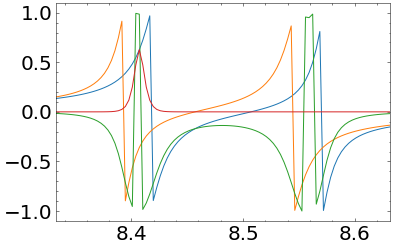

In [34]:
input_output_estimation(l=30, κ=2*π*50e-3, η=4, rG=0.03, rg=0.1, T1=100e-6, quiet=False, plot=True)

In [35]:
all_η = np.linspace(1, 10, 21)
phase_gate_30m_50MHz = np.array(
    job(lambda η: input_output_estimation(κ=2*π*50e-3, l=30, η=η, rG=0.03, rg=0.1, T1=50e-6, quiet=False, plot=False),
        np.linspace(1, 10, 21), single=True)
)
phase_gate_30m_100MHz = np.array(
    job(lambda η: input_output_estimation(κ=2*π*100e-3, l=30, η=η, rG=0.03, rg=0.1, T1=50e-6, quiet=False, plot=False),
        np.linspace(1, 10, 21), single=True)
)
phase_gate_5m_50MHz = np.array(
    job(lambda η: input_output_estimation(κ=2*π*50e-3, l=5, η=η, rG=0.03, rg=0.1, T1=50e-6, quiet=False, plot=False),
        np.linspace(1, 10, 21), single=True)
)
phase_gate_5m_100MHz = np.array(
    job(lambda η: input_output_estimation(κ=2*π*100e-3, l=5, η=η, rG=0.03, rg=0.1, T1=50e-6, quiet=False, plot=False),
        np.linspace(1, 10, 21), single=True)
)

(2.8325270579089445e-06, 0.15707959681346378, 1.0009008103179216, 0.030027017453460814) 15.707966854552371
χ  = 2π x 0.025 GHz
κ  = 2π x 0.050 GHz,  κmin = 2π x 0.020 GHz
η  = 1.0, ηmax = 2.5
g  = 2π x 0.250 GHz
δ  = 2π x 2.500 GHz
G  = 2π x 0.075 GHz
Ω  = ω1 + 1.000xG 
γ  = 2π x 0.000 MHz
Tγ = 353 μs
T1 = 50 μs
tpulse = 0.127 μs = 0.4 * tprop
tproto = 0.447121 μs
1-Fsc  = 0.289245 scattering fidelity
1-Fγ   = 0.00126568 Purcell decay
1-Fqb  = 0.0189691 qubit decay

(2.8325270579089445e-06, 0.15707959681346378, 1.0009008103179216, 0.030027017453460814) 15.707966854552371
χ  = 2π x 0.025 GHz
κ  = 2π x 0.050 GHz,  κmin = 2π x 0.020 GHz
η  = 1.45, ηmax = 2.5
g  = 2π x 0.250 GHz
δ  = 2π x 2.500 GHz
G  = 2π x 0.075 GHz
Ω  = ω1 + 1.000xG 
γ  = 2π x 0.000 MHz
Tγ = 353 μs
T1 = 50 μs
tpulse = 0.185 μs = 0.6 * tprop
tproto = 0.504417 μs
1-Fsc  = 0.144166 scattering fidelity
1-Fγ   = 0.00142775 Purcell decay
1-Fqb  = 0.0213737 qubit decay

(2.8325270579089445e-06, 0.15707959681346378, 1.000900810

/tmp/ipykernel_126/3894530683.py:70: RuntimeWarning: divide by zero encountered in double_scalars
  if (1+r*np.cos(φ))/(1+r*r+2*r*np.cos(φ)) <= 1:


(2.577717338103707e-06, 0.15342427578579435, 1.0008593378970203, 0.029327058472364935) 16.08220790116187
χ  = 2π x 0.025 GHz
κ  = 2π x 0.050 GHz,  κmin = 2π x 0.120 GHz
η  = 9.55, ηmax = 0.4
g  = 2π x 0.250 GHz
δ  = 2π x 2.560 GHz
G  = 2π x 0.075 GHz
Ω  = ω1 + 1.000xG 
γ  = 2π x 0.000 MHz
Tγ = 388 μs
T1 = 50 μs
tpulse = 1.216 μs = 22.9 * tprop
tproto = 1.269151 μs
1-Fsc  = 2.93388e-09 scattering fidelity
1-Fγ   = 0.00326617 Purcell decay
1-Fqb  = 0.0526035 qubit decay

(2.5777173334435374e-06, 0.1534242757165112, 1.0008593378962436, 0.029327058459098703) 16.08220790842425
χ  = 2π x 0.025 GHz
κ  = 2π x 0.050 GHz,  κmin = 2π x 0.120 GHz
η  = 10.0, ηmax = 0.4
g  = 2π x 0.250 GHz
δ  = 2π x 2.560 GHz
G  = 2π x 0.075 GHz
Ω  = ω1 + 1.000xG 
γ  = 2π x 0.000 MHz
Tγ = 388 μs
T1 = 50 μs
tpulse = 1.273 μs = 23.9 * tprop
tproto = 1.326447 μs
1-Fsc  = 1.01507e-09 scattering fidelity
1-Fγ   = 0.00341337 Purcell decay
1-Fqb  = 0.0549119 qubit decay

(5.665055654296614e-06, 0.314159214937059, 1.0009008

(1e-05, 0.5)

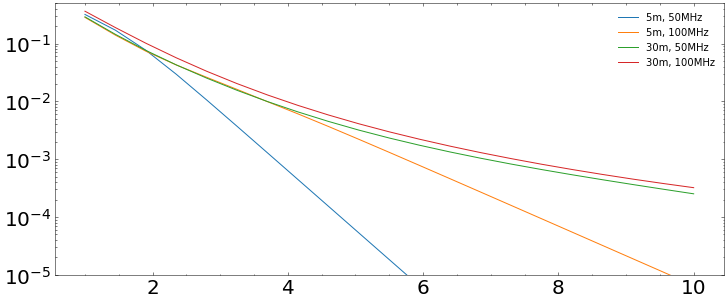

In [40]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(all_η, 1-phase_gate_5m_50MHz[:,0], label='5m, 50MHz')
ax.plot(all_η, 1-phase_gate_5m_100MHz[:,0], label='5m, 100MHz')
ax.plot(all_η, 1-phase_gate_30m_50MHz[:,0], label='30m, 50MHz')
ax.plot(all_η, 1-phase_gate_30m_100MHz[:,0], label='30m, 100MHz')
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.set_ylim([1e-5,0.5])

(0.01, 1)

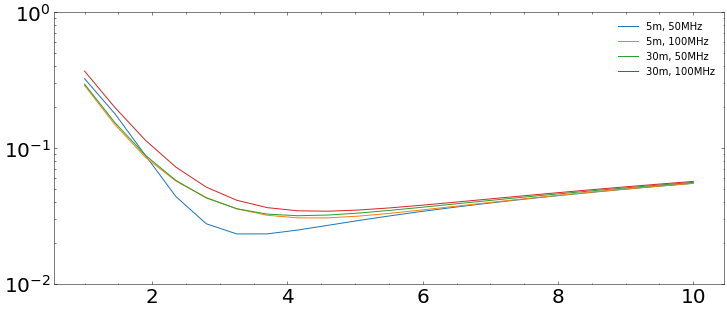

In [45]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(all_η, 1-np.prod(phase_gate_5m_50MHz[:,[0,1]],axis=1)*np.exp(-2*phase_gate_5m_50MHz[:,-1]/50e3), label='5m, 50MHz')
ax.plot(all_η, 1-np.prod(phase_gate_5m_100MHz[:,[0,1]],axis=1)*np.exp(-2*phase_gate_5m_50MHz[:,-1]/50e3), label='5m, 100MHz')
ax.plot(all_η, 1-np.prod(phase_gate_30m_50MHz[:,[0,1]],axis=1)*np.exp(-2*phase_gate_5m_50MHz[:,-1]/50e3), label='30m, 50MHz')
ax.plot(all_η, 1-np.prod(phase_gate_30m_100MHz[:,[0,1]],axis=1)*np.exp(-2*phase_gate_5m_50MHz[:,-1]/50e3), label='30m, 100MHz')
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.set_ylim([1e-2,1])

(0.01, 1)

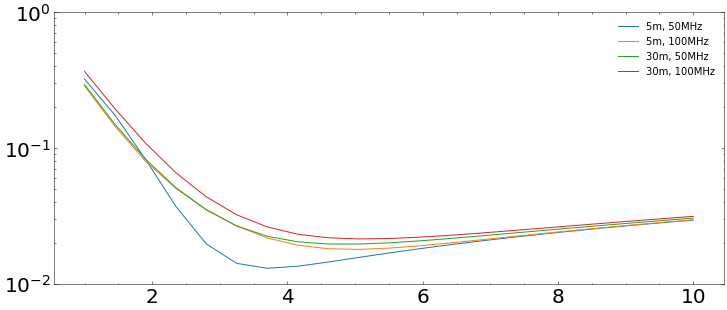

In [46]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(all_η, 1-np.prod(phase_gate_5m_50MHz[:,[0,1]],axis=1)*np.exp(-2*phase_gate_5m_50MHz[:,-1]/100e3), label='5m, 50MHz')
ax.plot(all_η, 1-np.prod(phase_gate_5m_100MHz[:,[0,1]],axis=1)*np.exp(-2*phase_gate_5m_50MHz[:,-1]/100e3), label='5m, 100MHz')
ax.plot(all_η, 1-np.prod(phase_gate_30m_50MHz[:,[0,1]],axis=1)*np.exp(-2*phase_gate_5m_50MHz[:,-1]/100e3), label='30m, 50MHz')
ax.plot(all_η, 1-np.prod(phase_gate_30m_100MHz[:,[0,1]],axis=1)*np.exp(-2*phase_gate_5m_50MHz[:,-1]/100e3), label='30m, 100MHz')
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.set_ylim([1e-2,1])